In [1]:
import pandas as pd
from datetime import timedelta, datetime
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams

from sklearn import metrics
import math

#ignore warnings
import warnings
warnings.filterwarnings("ignore")

from pipeline import evaluate, plot_and_eval

# Goals

# Takeaways

# Plan

# Acquire

- read in master .csv file of original 8 .csv files.

- read in 225 rows and 9 columns.

- read in file with 'Date' column as DatetimeIndex.

In [2]:
df = pd.read_csv('fitbit_master.csv', index_col='Date', parse_dates=True)

In [3]:
df.shape

(225, 9)

# Prepare

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 225 entries, 2018-04-26 to 2018-12-06
Data columns (total 9 columns):
Calories Burned           225 non-null int64
Steps                     225 non-null int64
Distance                  225 non-null float64
Floors                    225 non-null int64
Minutes Sedentary         225 non-null int64
Minutes Lightly Active    225 non-null int64
Minutes Fairly Active     225 non-null int64
Minutes Very Active       225 non-null int64
Activity Calories         225 non-null int64
dtypes: float64(1), int64(8)
memory usage: 17.6 KB


## Resample by Day by Sum

In [5]:
df = df.resample('D').sum()

## Check Latest Date

- 2018-12-06

- projection will be two weeks out from this date

In [6]:
df.index.max()

Timestamp('2018-12-06 00:00:00')

In [7]:
df.index.min()

Timestamp('2018-04-26 00:00:00')

## Rename Columns

In [8]:
df.columns

Index(['Calories Burned', 'Steps', 'Distance', 'Floors', 'Minutes Sedentary',
       'Minutes Lightly Active', 'Minutes Fairly Active',
       'Minutes Very Active', 'Activity Calories'],
      dtype='object')

In [9]:
df = df.rename(columns={'Calories Burned': 'calories_burned', 'Steps': 'steps', 'Distance': 'distance', 
                  'Floors': 'floors', 'Minutes Sedentary': 'sedentary_mins', 'Minutes Lightly Active': 'lightly_active_mins',
                  'Minutes Fairly Active': 'fairly_active_mins', 'Minutes Very Active': 'very_active_mins', 
                'Activity Calories': 'activity_calories'})

In [10]:
df.head()

,calories_burned,steps,distance,floors,sedentary_mins,lightly_active_mins,fairly_active_mins,very_active_mins,activity_calories
Date,,,,,,,,,
2018-04-26,2635,2931,1.4,2,1347,93,0,0,566
2018-04-27,3649,9971,4.7,19,1158,219,46,17,1752
2018-04-28,3379,3521,1.7,2,702,155,22,11,1124
2018-04-29,2851,1639,0.8,0,891,122,0,0,602
2018-04-30,2825,1323,0.6,0,880,104,0,0,540


## Add column with total of all activity

In [11]:
df['active_total'] = df.lightly_active_mins + df.fairly_active_mins + df.very_active_mins

## Add column with ratio of active time to sedentary time

In [12]:
df['ratio_act_sed'] = df.active_total/df.sedentary_mins

## Add column with ratio of distance to steps (stride)

In [13]:
df['stride'] = df.distance/ df.steps

## Add column with ratio of calories to steps

In [14]:
df['ratio_cal_steps'] = df.calories_burned/df.steps

## Add column with ratio of active time to calories

In [15]:
df['ratio_active_cal'] = df.active_total/df.calories_burned

## Add column with ratio of sedentary time to calories

In [16]:
df['ratio_sed_cal'] = df.sedentary_mins/df.calories_burned

## Add a Month Column

In [17]:
df['month'] = df.index.month

## Add a Day of the Week Column

In [18]:
df['weekday'] = df.index.strftime('%w %a')

In [19]:
df.head()

,calories_burned,steps,distance,floors,sedentary_mins,lightly_active_mins,fairly_active_mins,very_active_mins,activity_calories,active_total,ratio_act_sed,stride,ratio_cal_steps,ratio_active_cal,ratio_sed_cal,month,weekday
Date,,,,,,,,,,,,,,,,,
2018-04-26,2635,2931,1.4,2,1347,93,0,0,566,93,0.069042,0.000478,0.899011,0.035294,0.511195,4,4 Thu
2018-04-27,3649,9971,4.7,19,1158,219,46,17,1752,282,0.243523,0.000471,0.365961,0.077281,0.317347,4,5 Fri
2018-04-28,3379,3521,1.7,2,702,155,22,11,1124,188,0.267806,0.000483,0.959671,0.055638,0.207754,4,6 Sat
2018-04-29,2851,1639,0.8,0,891,122,0,0,602,122,0.136925,0.000488,1.739475,0.042792,0.312522,4,0 Sun
2018-04-30,2825,1323,0.6,0,880,104,0,0,540,104,0.118182,0.000454,2.135299,0.036814,0.311504,4,1 Mon


# Explore

- Begin stage with 225 rows and 17 columns

- 33 Thursdays, 32 each Friday through Wednesday

    - We will drop the first row which is a Thursday to keep weekday count equal.

In [20]:
df.shape

(225, 17)

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 225 entries, 2018-04-26 to 2018-12-06
Freq: D
Data columns (total 17 columns):
calories_burned        225 non-null int64
steps                  225 non-null int64
distance               225 non-null float64
floors                 225 non-null int64
sedentary_mins         225 non-null int64
lightly_active_mins    225 non-null int64
fairly_active_mins     225 non-null int64
very_active_mins       225 non-null int64
activity_calories      225 non-null int64
active_total           225 non-null int64
ratio_act_sed          225 non-null float64
stride                 213 non-null float64
ratio_cal_steps        225 non-null float64
ratio_active_cal       225 non-null float64
ratio_sed_cal          225 non-null float64
month                  225 non-null int64
weekday                225 non-null object
dtypes: float64(6), int64(10), object(1)
memory usage: 31.6+ KB


In [22]:
df.describe()

,calories_burned,steps,distance,floors,sedentary_mins,lightly_active_mins,fairly_active_mins,very_active_mins,activity_calories,active_total,ratio_act_sed,stride,ratio_cal_steps,ratio_active_cal,ratio_sed_cal,month
count,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,213.000000,225.000000,225.000000,225.000000,225.000000
mean,3401.911111,8536.186667,4.052000,12.591111,809.520000,188.235556,14.920000,33.871111,1484.546667,237.026667,0.340755,0.000471,inf,0.066193,0.255918,8.008889
std,632.426578,5255.746608,2.507472,25.844174,243.232639,75.170001,15.363535,37.195986,747.795790,103.121761,0.203614,0.000048,NaN,0.023508,0.129883,2.144326
min,799.000000,0.000000,0.000000,0.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.189401,0.000000,0.035044,4.000000
25%,3069.000000,4714.000000,2.200000,2.000000,654.000000,158.000000,3.000000,2.000000,1062.000000,187.000000,0.213303,0.000469,0.308263,0.060267,0.176864,6.000000
50%,3385.000000,7806.000000,3.700000,7.000000,750.000000,203.000000,11.000000,15.000000,1481.000000,253.000000,0.324934,0.000472,0.429876,0.072244,0.219793,8.000000
75%,3765.000000,12380.000000,5.900000,13.000000,877.000000,236.000000,21.000000,63.000000,1962.000000,299.000000,0.446337,0.000477,0.635178,0.079378,0.282792,10.000000
max,5199.000000,25512.000000,12.000000,195.000000,1440.000000,349.000000,78.000000,154.000000,3596.000000,505.000000,1.256219,0.000581,inf,0.110248,0.671642,12.000000


## Equalize Weekdays

- drop the first row leaving us with 224 rows, 17 columns

In [23]:
# retrieve a weekday count, drop the first Thursday '2018-04-26'

df['weekday'].value_counts()

4 Thu    33
0 Sun    32
2 Tue    32
5 Fri    32
3 Wed    32
1 Mon    32
6 Sat    32
Name: weekday, dtype: int64

In [24]:
# drop the first row, an extra Thursday

df = df[df.index != "2018-04-26"]

## Fill Stride Column NaNs with 0

In [25]:
df['stride'] = df.stride.fillna(0)

In [26]:
df = df.replace([np.inf, -np.inf], 0)

In [27]:
df.isnull().sum()

calories_burned        0
steps                  0
distance               0
floors                 0
sedentary_mins         0
lightly_active_mins    0
fairly_active_mins     0
very_active_mins       0
activity_calories      0
active_total           0
ratio_act_sed          0
stride                 0
ratio_cal_steps        0
ratio_active_cal       0
ratio_sed_cal          0
month                  0
weekday                0
dtype: int64

In [28]:
(df == 0).astype(int).sum().sort_values(ascending = False)

very_active_mins       50
fairly_active_mins     45
floors                 31
stride                 14
distance               14
steps                  12
ratio_cal_steps        12
activity_calories       9
ratio_active_cal        9
ratio_act_sed           9
active_total            9
lightly_active_mins     9
weekday                 0
sedentary_mins          0
month                   0
ratio_sed_cal           0
calories_burned         0
dtype: int64

## Look at Days with 0 Steps

- There are 0 values for steps in the following dates/date ranges

    - 6/6 - 6/7
    - 6/11
    - 6/26 - 6/30
    - 7/3 - 7/6
    
- We will look for trends before and after the breaks to decide how to handle these rows.

In [29]:
df[df['steps'] == 0]

,calories_burned,steps,distance,floors,sedentary_mins,lightly_active_mins,fairly_active_mins,very_active_mins,activity_calories,active_total,ratio_act_sed,stride,ratio_cal_steps,ratio_active_cal,ratio_sed_cal,month,weekday
Date,,,,,,,,,,,,,,,,,
2018-06-06,2145,0,0.0,0,1440,0,0,0,0,0,0.000000,0.0,0.0,0.000000,0.671329,6,3 Wed
2018-06-07,2146,0,0.0,0,1440,0,0,0,0,0,0.000000,0.0,0.0,0.000000,0.671016,6,4 Thu
2018-06-11,2146,0,0.0,0,1440,0,0,0,0,0,0.000000,0.0,0.0,0.000000,0.671016,6,1 Mon
2018-06-26,2144,0,0.0,0,1440,0,0,0,0,0,0.000000,0.0,0.0,0.000000,0.671642,6,2 Tue
2018-06-27,2145,0,0.0,0,1440,0,0,0,0,0,0.000000,0.0,0.0,0.000000,0.671329,6,3 Wed
2018-06-28,2145,0,0.0,0,1440,0,0,0,0,0,0.000000,0.0,0.0,0.000000,0.671329,6,4 Thu
2018-06-29,2180,0,0.0,0,1437,3,0,0,39,3,0.002088,0.0,0.0,0.001376,0.659174,6,5 Fri
2018-06-30,2145,0,0.0,0,1440,0,0,0,0,0,0.000000,0.0,0.0,0.000000,0.671329,6,6 Sat
2018-07-03,2144,0,0.0,0,1440,0,0,0,0,0,0.000000,0.0,0.0,0.000000,0.671642,7,2 Tue


## Calculate Mean Values by Weekdays

In [30]:
# Means for Mondays

df[df['weekday'] == '1 Mon'].median()

calories_burned        3196.500000
steps                  6187.000000
distance                  2.900000
floors                    6.000000
sedentary_mins          761.000000
lightly_active_mins     196.500000
fairly_active_mins        8.000000
very_active_mins         12.000000
activity_calories      1268.500000
active_total            220.000000
ratio_act_sed             0.272030
stride                    0.000471
ratio_cal_steps           0.497201
ratio_active_cal          0.069556
ratio_sed_cal             0.239413
month                     8.000000
dtype: float64

In [31]:
# Means for Tuesdays

df[df['weekday'] == '2 Tue'].median()

calories_burned        3388.500000
steps                  7298.000000
distance                  3.450000
floors                    6.000000
sedentary_mins          774.000000
lightly_active_mins     196.000000
fairly_active_mins        9.000000
very_active_mins         11.500000
activity_calories      1401.500000
active_total            240.500000
ratio_act_sed             0.324132
stride                    0.000471
ratio_cal_steps           0.442387
ratio_active_cal          0.070076
ratio_sed_cal             0.230211
month                     8.000000
dtype: float64

In [32]:
# Means for Wednesdays

df[df['weekday'] == '3 Wed'].median()

calories_burned        3329.500000
steps                  7600.000000
distance                  3.600000
floors                    6.500000
sedentary_mins          770.500000
lightly_active_mins     200.000000
fairly_active_mins        7.500000
very_active_mins         13.500000
activity_calories      1368.000000
active_total            236.500000
ratio_act_sed             0.306100
stride                    0.000471
ratio_cal_steps           0.405560
ratio_active_cal          0.069940
ratio_sed_cal             0.228370
month                     8.000000
dtype: float64

In [33]:
# Means for Thursdays

df[df['weekday'] == '4 Thu'].median()

calories_burned        3469.000000
steps                  9556.500000
distance                  4.500000
floors                    7.000000
sedentary_mins          759.000000
lightly_active_mins     206.500000
fairly_active_mins       10.000000
very_active_mins         16.500000
activity_calories      1673.500000
active_total            269.000000
ratio_act_sed             0.348294
stride                    0.000473
ratio_cal_steps           0.342629
ratio_active_cal          0.073186
ratio_sed_cal             0.223888
month                     8.000000
dtype: float64

In [34]:
# Means for Wednesdays

df[df['weekday'] == '5 Fri'].median()

calories_burned        3470.000000
steps                  8872.000000
distance                  4.200000
floors                    7.000000
sedentary_mins          759.500000
lightly_active_mins     203.000000
fairly_active_mins       11.500000
very_active_mins         14.000000
activity_calories      1623.000000
active_total            274.000000
ratio_act_sed             0.325513
stride                    0.000471
ratio_cal_steps           0.356122
ratio_active_cal          0.073966
ratio_sed_cal             0.216499
month                     8.000000
dtype: float64

In [35]:
# Means for Wednesdays

df[df['weekday'] == '6 Sat'].median()

calories_burned        3421.500000
steps                  8792.500000
distance                  4.150000
floors                    7.000000
sedentary_mins          688.000000
lightly_active_mins     205.000000
fairly_active_mins       19.500000
very_active_mins         20.500000
activity_calories      1597.500000
active_total            263.000000
ratio_act_sed             0.375019
stride                    0.000474
ratio_cal_steps           0.347621
ratio_active_cal          0.076401
ratio_sed_cal             0.198231
month                     8.000000
dtype: float64

## Plots

### Calories Burned by Month

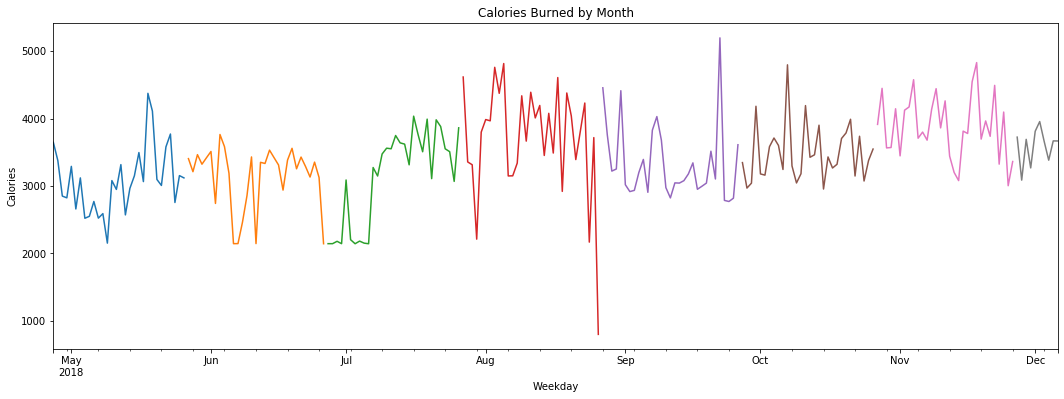

In [36]:
df['calories_burned']['2018-04-27':'2018-05-26'].plot(figsize= (18,6))
df['calories_burned']['2018-05-27':'2018-06-26'].plot()
df['calories_burned']['2018-06-27':'2018-07-26'].plot()
df['calories_burned']['2018-07-27':'2018-08-26'].plot()
df['calories_burned']['2018-08-27':'2018-09-26'].plot()
df['calories_burned']['2018-09-27':'2018-10-26'].plot()
df['calories_burned']['2018-10-27':'2018-11-26'].plot()
df['calories_burned']['2018-11-27':'2018-12-06'].plot()

plt.xlabel('Weekday')
plt.ylabel('Calories')
plt.title('Calories Burned by Month')
plt.show()

### Average Calories Burned by Weekday

- Most calores burned on Saturdays and Sundays

In [37]:
df.groupby(['weekday']).calories_burned.mean()

weekday
0 Sun    3551.46875
1 Mon    3242.75000
2 Tue    3304.09375
3 Wed    3270.46875
4 Thu    3450.65625
5 Fri    3464.71875
6 Sat    3553.18750
Name: calories_burned, dtype: float64

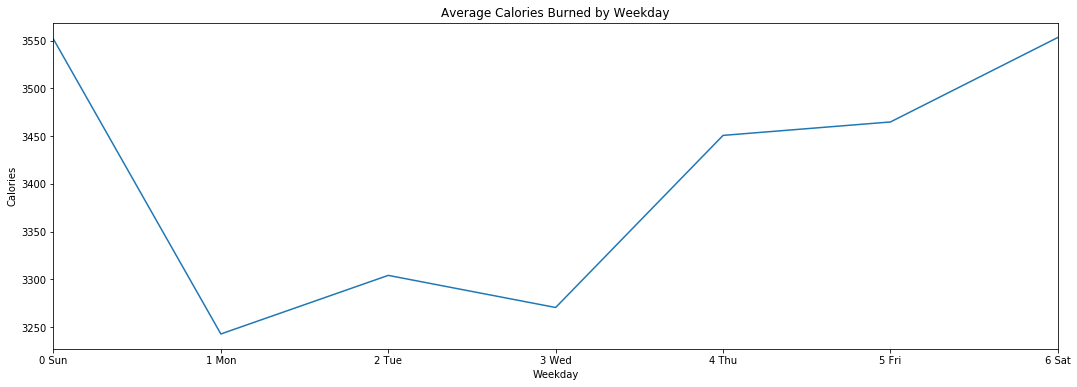

In [38]:
df.groupby(['weekday'])['calories_burned'].mean().plot(figsize = (18,6))

plt.xlabel('Weekday')
plt.ylabel('Calories')
plt.title('Average Calories Burned by Weekday')
plt.show()

### Number of Steps by Day

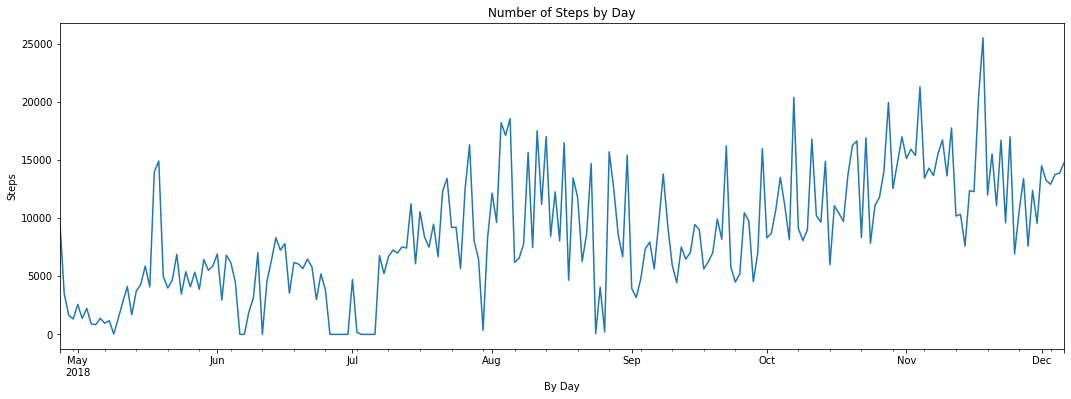

In [39]:
df['steps'].plot(figsize=(18,6))

plt.xlabel('By Day')
plt.ylabel('Steps')
plt.title('Number of Steps by Day')
plt.show()

## Sedentary Mins Vs. Active Mins

<Figure size 864x864 with 0 Axes>

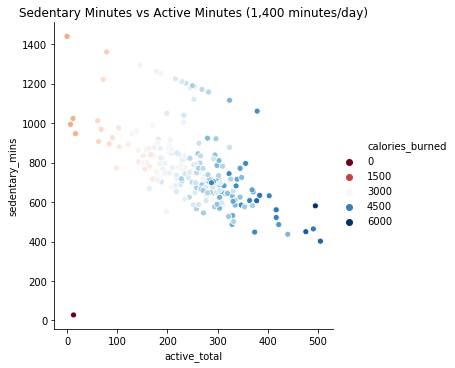

In [40]:
plt.figure(figsize = (12,12))
sns.relplot(x='active_total', y='sedentary_mins', data=df, alpha = 1, hue = 'calories_burned', palette = 'RdBu')
plt.title('Sedentary Minutes vs Active Minutes (1,400 minutes/day)')
plt.show()

## Drop Columns - Month, Weekday, and Floors for Modeling

In [41]:
df.drop(columns=['month', 'weekday', 'floors'], inplace=True)

### Takeaways:  Explore

- 

# Impute

- Use a lambda function to convert values of 0 in the steps column to Nans.

- Decide on the best way to handle the missing step values in the data before going on to model using same methods to predict future values.

### Impute Median Values for Steps and Create Column rm_steps

In [42]:
df.steps = df.steps.apply(lambda x: np.nan if x == 0 else x)

In [43]:
df = df.assign(RollingMedian=df.steps.fillna(df.steps.rolling(14,min_periods=1,).median()))

In [44]:
df = df.rename(columns = {'RollingMedian' : 'rm_steps'})

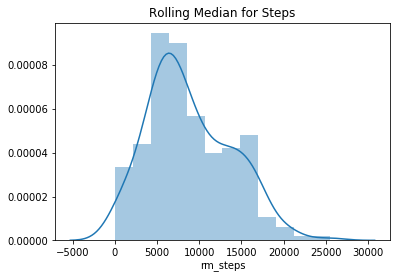

In [45]:
sns.distplot(df.rm_steps)

plt.title('Rolling Median for Steps')
plt.show()

### Impute Median Values for Distance and Create Column rm_distance

In [46]:
df.distance = df.distance.apply(lambda x: np.nan if x == 0 else x)

In [47]:
df = df.assign(RollingMedian=df.distance.fillna(df.distance.rolling(14,min_periods=1,).median()))

In [48]:
df = df.rename(columns = {'RollingMedian' : 'rm_distance'})

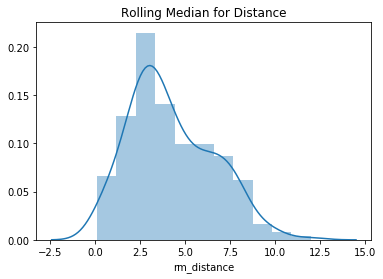

In [49]:
sns.distplot(df.rm_distance)

plt.title('Rolling Median for Distance')
plt.show()

## Calculate Rolling Mean

In [54]:
df = df.assign(steps_14_day_mean=df.steps.fillna(df.steps.rolling(14,min_periods=1,).mean()))

In [55]:
#df['steps_14_day_mean'] = df['steps'].rolling(window=14).mean()

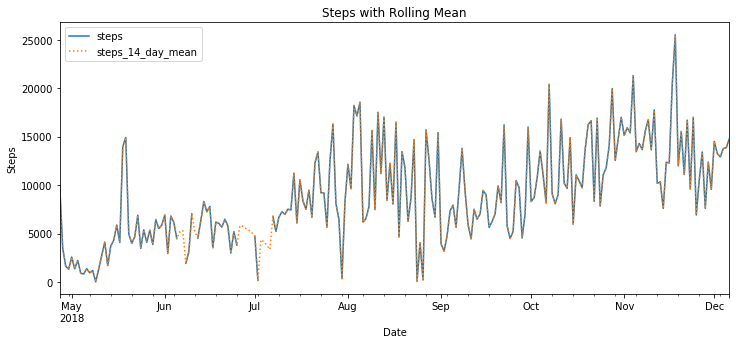

In [57]:
df['steps'].plot(figsize=(12,5))
df['steps_14_day_mean'].plot(style=':')

plt.title('Steps with Rolling Mean')
plt.ylabel('Steps')
plt.legend()
plt.show()

In [58]:
df['steps_14_day_mean'].isnull().sum()

0

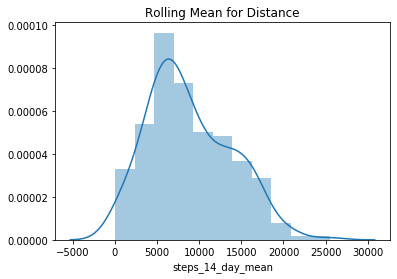

In [59]:
sns.distplot(df.steps_14_day_mean)

plt.title('Rolling Mean for Distance')
plt.show()

## Expanding Steps

In [ ]:
df['steps_14_day_expand'] = df['steps'].expanding(min_periods=14).mean()

In [ ]:
df[['steps', 'steps_14_day_expand', 'steps_7_day_mean']].expanding(min_periods=14).mean().plot(figsize=(12,5))

plt.show()

## Simple Moving Average (SMA)

- Create rolling_median Column

- Create a column called 'rolling_median' that contains the original values for 'steps' and imputed values of the median for steps where there are NaNs.

- This method can be skewed by more extreme historical values.

In [ ]:
df = df.assign(rolling_median=df.steps.fillna(df.steps.rolling(14,min_periods=1,).median()))

In [ ]:
df.head(10)

## ETS Decomposition

- Error-Trend-Decomposition

- It looks like there is a lot of noise between August and September.

- It is easy to see the seasonality present.

- The trend is upward for the most part.

In [ ]:
result = seasonal_decompose(df['rolling_median'], model='additive')

In [ ]:
rcParams['figure.figsize']=(12,5)

result.plot()

plt.show()

## Exponentially Weighted Moving Average (EWMA)

- This allows the more recent data to be weighted more than the older data

- This might help reduce the noise in the data

- This could help us make better predictions and avoid problems with historical data issues.

In [ ]:
df['EWMA_14'] = df['steps'].ewm(span=14).mean()

In [ ]:
df[['rolling_median', 'steps', 'EWMA_14']].plot(style=[':', '--', '-'])

plt.title('Steps Imputing Method Comparison')
plt.ylabel('Steps')
plt.show()

## Comparison of All Impute Methods

In [ ]:
df[['steps', 'rm_steps', 'steps_14_day_expand', 'steps_14_day_mean', 'EWMA_14']].expanding(min_periods=14).mean().plot(style=['-', '--', ':', ':', '--'])

plt.ylabel('Steps')
plt.title('Comparison of Imputation Methods for Steps')
plt.show()

### Takeaways: Impute

- 

# Correlation with Steps

## Increase in Steps by Month

In [ ]:
df['rm_steps'].resample('M').mean().plot.bar(figsize=(12,8))

plt.xlabel('Month')
plt.ylabel('Steps')
plt.title('Steps by Month')
plt.show()

## Steps and Calories Burned

- Sedentary mins looks negatively correlated with calories burned.

- Lightly active looks correlated with calories burned more than either very or fairly active.

In [ ]:
df[['sedentary_mins', 'very_active_mins', 'fairly_active_mins', 'lightly_active_mins', 'calories_burned']].plot()

plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('Correlations with Calories Burned')
plt.ylabel('Calories and Minutes')
plt.show()

In [ ]:
df.isnull().sum()

In [ ]:
df.sort_values(by='rolling_median')

## Steps and Trend

- using Hodrick-Prescott filter to find the cycle and trend of steps

- here you can see where the actual steps are above or below the trend

In [ ]:
steps_cycle, steps_trend = hpfilter(df['rolling_median'], lamb=600)

In [ ]:
df['steps_trend'] = steps_trend

In [ ]:
df[['steps_trend', 'rolling_median']].plot(figsize=(12,5))

plt.title('Steps and Steps Trend')
plt.ylabel('Steps')
plt.show()

## Percent Difference from First to Last Day

- There was a 48% increase in steps and distance from the first to the last day in the data set.

- There was a 358% increase in very_active_mins!

- There was a 77% increase in the ration_act_sed.

In [ ]:
100 * (df.loc['2018-12-6'] - df.loc['2018-04-27'])/ df.loc['2018-04-27']

### Correlation: Takeaways

- 

# Split Train and Test

- We want our test set to be about 20% of of our data set or at least as large as the future prediction we would like to make.

- We want our test set to be at least 2 weeks, since we want to forecast 2 weeks into the future past 2018-12-06.

- train (210, 2)

- test (14, 2)

In [ ]:
target_vars = ['rolling_median', 'calories_burned']
df = df.resample('D')[target_vars].sum()

In [ ]:
train = df.loc[:'2018-11-22']
test = df.loc['2018-11-23':]

In [ ]:
yhat = pd.DataFrame(test[target_vars])

In [ ]:
for var in target_vars:
    yhat[var] = int(train[var][-1:])

In [ ]:
yhat.head()

In [ ]:
train.shape

In [ ]:
test.shape

In [ ]:
print('Observations: %d' % (len(df)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

In [ ]:
train.head(1), test.head(1)

In [ ]:
# validate train test split

for var in range(len(target_vars)):
    plt.figure(figsize=(12, 6))
    plt.plot(train[target_vars[var]])
    plt.plot(test[target_vars[var]])
    #plt.legend()
    plt.show()

# Model

## Basline: Last Observed Value

- Get a baseline model using this simple forecasting method.

- Predict all future values to be the last observed value.

In [ ]:
def evaluate(target_var, train, test, output=True):
    mse = metrics.mean_squared_error(test[target_var], yhat[target_var])
    rmse = math.sqrt(mse)

    if output:
        print('MSE:  {}'.format(mse))
        print('RMSE: {}'.format(rmse))
    else:
        return mse, rmse

In [ ]:
evaluate(target_var=target_vars, train=train, test=test, output=True)

In [ ]:
def plot_and_eval(target_vars, train, test, metric_fmt = '{:.2f}', linewidth = 4):
    if type(target_vars) is not list:
        target_vars = [target_vars]

    plt.figure(figsize=(16, 8))
    plt.plot(train[target_vars],label='Train', linewidth=1)
    plt.plot(test[target_vars], label='Test', linewidth=1)

    for var in target_vars:
        mse, rmse = evaluate(target_var = var, train = train, test = test, output=False)
        plt.plot(yhat[var], linewidth=linewidth)
        print(f'{var} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse))

    plt.show()

In [ ]:
plot_and_eval(target_vars=target_vars, train = train, test = test)

## Holt Winters Model

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [ ]:
fitted_model = ExponentialSmoothing(train['rolling_median'],
                                   trend='add', seasonal='add',
                                   seasonal_periods=)

### Takeaways: Model

- 

# Forecast

# Final Takeaways

- Faith:


- Sean: